<a href="https://colab.research.google.com/github/tpathanjali/ML/blob/master/Sentiment_analysis_using_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

below will install pydrive to connect to drive and sk learn

# sentiment analysis

In [3]:
!pip install -U -q sklearn
!pip install -U -q PyDrive

    100% |████████████████████████████████| 993kB 17.4MB/s 


Below code will be used to authenticate the google drive to use data on drive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

TrainFile = '1uitbEQqxS1E7B_w1JoxOBM9A-A06kMPT'
downloaded = drive.CreateFile({'id': TrainFile})
downloaded.GetContentFile('twittertrain.txt')
TestFile = '1ZI0pmAytx1JbCKKR4mfdxErQilljYnuA'
downloaded2 = drive.CreateFile({'id': TestFile})
downloaded2.GetContentFile('twitterTST.txt')

importing necessary **libraries**

In [1]:
import sklearn as sklearn
from string import punctuation
import re
from nltk.corpus import wordnet
import keras as kr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import gensim
from gensim.models.word2vec import Word2Vec 
from wordcloud import WordCloud
from nltk import word_tokenize, sent_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, SpatialDropout1D, Conv1D, GlobalMaxPooling1D, MaxPooling1D, LSTM
from keras.layers import Embedding
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras.layers import SimpleRNN
from keras.layers.wrappers import Bidirectional
from nltk.stem.porter import *
nltk.download('wordnet')


Using TensorFlow backend.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

**loading the train and test data**

In [0]:
twitter_train=pd.read_csv('twittertrain.txt',sep=',',encoding='latin-1')
twitter_test=pd.read_csv('twitterTST.txt',sep=',',encoding='latin-1')

below code will clean the tweets for further analysis

*   **clean_tweet ** will clear all the unncessary punctuation and url/links
*   **RegexpReplacer** will replace patterns example isnt will be replaced to is not
*   **RepeatReplacer** will remove unnecessary letters in words eg ohhh myyyy godd will be replaced as oh my god
*   **Integrate** will integrate all the above functions to give the output



In [0]:
def clean_tweet(tweet): 
    X= ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(\d)|(#(\w+))", " ", tweet).split())
    return(X.lower())
replacement_patterns = [(r'its', 'it is'),(r'im', 'i am'),(r'isnt', 'is not'),(r'thats', 'that is'),(r'won\'t', 'will not'),(r'can\'t', 'can not'),(r'i\'m', 'i am'),(r'ain\'t', 'is not'),(r'(\w+)\'ll', '\g<1> will'),(r'(\w+)n\'t', '\g<1> not'),(r'(\w+)\'ve', '\g<1> have'),(r'(\w+)\'s', '\g<1> is'),(r'(\w+)\'re', '\g<1> are'),(r'(\w+)\'d', '\g<1> would')]
class RegexpReplacer(object): 
    def __init__(self, patterns=replacement_patterns): 
        self.patterns = [(re.compile(regex), repl) for (regex, repl) in patterns] 
    def replace(self, text):
        s = text 
        for (pattern, repl) in self.patterns: 
            (s, count) = re.subn(pattern, repl, s) 
        return s
class RepeatReplacer(object): 
    def __init__(self): 
        self.repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)') 
        self.repl = r'\1\2\3' 
    def replace(self, word): 
        if wordnet.synsets(word): 
            return word 
        repl_word = self.repeat_regexp.sub(self.repl, word) 
        if repl_word != word: 
            return self.replace(repl_word) 
        else: 
            return repl_word
def integrate(word):
  x=RegexpReplacer()
  y=RepeatReplacer()
  return(" ".join([y.replace(i) for i in clean_tweet(x.replace(word)).split(' ') if len(i) >2]))

a new column in created on existing train dataset, just to compare the original tweet and cleaned tweet. We don't require the original tweet anymore

In [0]:
twitter_train['cleaned']=twitter_train['SentimentText'].apply(integrate)

In [8]:
twitter_train[['Sentiment','SentimentText','cleaned']]

,Sentiment,SentimentText,cleaned
0,0,is so sad for my APL frie...,sad for apl friend
1,0,I missed the New Moon trail...,missed the new moon trailer
2,1,omg its already 7:30 :O,omg already
3,0,.. Omgaga. Im sooo im gunna CRy. I'...,omgaga so guna cry have been this dentist sinc...
4,0,i think mi bf is cheating on me!!! ...,think cheating
5,0,or i just worry too much?,just worry too much
6,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,just chilin
7,0,Sunny Again Work Tomorrow :-| ...,sunny again work tomorrow tonight
8,1,handed in my uniform today . i miss you ...,handed uniform today miss you already
9,1,hmmmm.... i wonder how she my number @-),hm wonder how she number


In [0]:
twitter_train['Sentiment'].value_counts()

1    56457
0    43532
Name: Sentiment, dtype: int64

seems, we have almost equal amount of sentiments for positive and negative sentiments. we can consider 30k of each for training and rest for test. Anyway we have an entirely bigger test dataset for testing

In [0]:
tokenized_tweets=twitter_train['cleaned'].apply(lambda x: x.split())

In [0]:

stemmer = PorterStemmer()

tokenized_tweets = tokenized_tweets.apply(lambda x: [stemmer.stem(i) for i in x])# stemming
#tokenized_tweets = tokenized_tweets.apply(lambda x: [i for i in x if len(i)>3])

In [0]:
for i in range(len(tokenized_tweets)):
      tokenized_tweets[i] = ' '.join(tokenized_tweets[i])

twitter_train['cleaned'] = tokenized_tweets

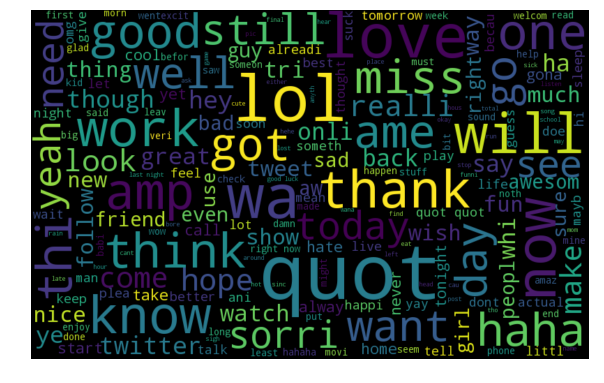

In [12]:
all_words = ' '.join([text for text in twitter_train['cleaned']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [0]:
twitter_train

,ItemID,Sentiment,SentimentText,cleaned
0,1,0,is so sad for my APL frie...,sad for apl friend
1,2,0,I missed the New Moon trail...,miss the new moon trailer
2,3,1,omg its already 7:30 :O,omg alreadi
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...,omgaga so guna cri have been thi dentist sinc ...
4,5,0,i think mi bf is cheating on me!!! ...,think cheat
5,6,0,or i just worry too much?,just worri too much
6,7,1,Juuuuuuuuuuuuuuuuussssst Chillin!!,just chilin
7,8,0,Sunny Again Work Tomorrow :-| ...,sunni again work tomorrow tonight
8,9,1,handed in my uniform today . i miss you ...,hand uniform today miss you alreadi
9,10,1,hmmmm.... i wonder how she my number @-),hm wonder how she number


In [0]:
tokenized_tweets

0                                       sad for apl friend
1                                miss the new moon trailer
2                                              omg alreadi
3        omgaga so guna cri have been thi dentist sinc ...
4                                              think cheat
5                                      just worri too much
6                                              just chilin
7                        sunni again work tomorrow tonight
8                      hand uniform today miss you alreadi
9                                 hm wonder how she number
10                                  must think about posit
11                        thank all the hater face all day
12                                 thi weekend ha suck far
13                             not show australia ani more
14                                            that you win
15                              thi the way feel right now
16       awh man complet useless now funni all can twitt

In [0]:
NUM_OF_WORDS=25000
comments_df_neg = twitter_train[['Sentiment','cleaned']][twitter_train['Sentiment']==0]
comments_df_pos = twitter_train[['Sentiment','cleaned']][twitter_train['Sentiment']==1].sample(n=comments_df_neg.shape[0],replace=False)


In [25]:
print(comments_df_neg.shape)
print(comments_df_pos.shape)

rev_df = pd.concat((comments_df_neg,comments_df_pos))
np.random.seed(42)
rev_df = rev_df.reindex(np.random.permutation(rev_df.index))
rev_df.reset_index(inplace=True, drop=True)

val_data=rev_df.sample(frac=0.1,random_state=42)
train_data=rev_df.drop(val_data.index)

(43532, 2)
(43532, 2)


In [26]:
tokenizer = Tokenizer(NUM_OF_WORDS=NUM_OF_WORDS,lower=True)
tokenizer.fit_on_texts(twitter_train['cleaned'])
sequences_train = tokenizer.texts_to_sequences(train_data['cleaned'])
sequences_valid=tokenizer.texts_to_sequences(val_data['cleaned'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 37117 unique tokens.


In [27]:
X_train = pad_sequences(sequences_train)
X_val = pad_sequences(sequences_valid,maxlen=X_train.shape[1])
y_train = np.asarray(train_data['Sentiment'])
y_val = np.asarray(val_data['Sentiment'])
print('Shape of X train and X validation tensor:', X_train.shape,X_val.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_val.shape)

Shape of X train and X validation tensor: (78358, 30) (8706, 30)
Shape of label train and validation tensor: (78358,) (8706,)


In [0]:
def model_evolution(model,X_test,y_test,threshold) :
  y_hat = model.predict_proba(X_test)
  y_hat = [y_hat > threshold]
  y_hat = y_hat[0].reshape(y_test.shape)
  print(confusion_matrix(y_test,y_hat))
  print(classification_report(y_test,y_hat))

In [0]:
# training:
epochs = 10
batch_size = 128
n_dim = 256
max_input_length = X_train.shape[1] # can be tuned at pad sequence and embedding leyer

#Evolution
threshold = 0.5

In [0]:
def model_evalute(X, Y) :
  # load model
  model_ann_one = load_model(X)
  # load weights
  model_ann_one.load_weights(Y)

  # Model Evolution
  model_evolution(model_ann_one,X_test,y_test,threshold)

In [35]:
# Shallow network- ANN

def ANN_one_hidden(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val) :
  
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(Flatten())
  
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  weight_file="ann.one.weights.best.hdf5"
  model_name ="ann.one.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
  
  return model_name,weight_file

# model fitting and saving into drive

x, y = ANN_one_hidden(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val)


Train on 78358 samples, validate on 8706 samples
Epoch 1/10
78358/78358 [==============================] - 96s 1ms/step - loss: 0.5220 - acc: 0.7343 - val_loss: 0.4820 - val_acc: 0.7663

Epoch 00001: val_acc improved from -inf to 0.76625, saving model to ann.one.weights.best.hdf5
Epoch 2/10
78358/78358 [==============================] - 95s 1ms/step - loss: 0.3884 - acc: 0.8251 - val_loss: 0.5259 - val_acc: 0.7556

Epoch 00002: val_acc did not improve from 0.76625
Epoch 3/10
78358/78358 [==============================] - 95s 1ms/step - loss: 0.2388 - acc: 0.8987 - val_loss: 0.6831 - val_acc: 0.7288

Epoch 00003: val_acc did not improve from 0.76625


In [39]:
def ANN_two_hidden(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val) :
  
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(Flatten())
  
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  weight_file="ann.two.weights.best.hdf5"
  model_name ="ann.two.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
 
  return model_name,weight_file

# model fitting and saving into drive

x, y = ANN_two_hidden(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val)


Train on 78358 samples, validate on 8706 samples
Epoch 1/10
78358/78358 [==============================] - 107s 1ms/step - loss: 0.5253 - acc: 0.7317 - val_loss: 0.4788 - val_acc: 0.7708

Epoch 00001: val_acc improved from -inf to 0.77085, saving model to ann.two.weights.best.hdf5
Epoch 2/10
78358/78358 [==============================] - 106s 1ms/step - loss: 0.3857 - acc: 0.8247 - val_loss: 0.5272 - val_acc: 0.7555

Epoch 00002: val_acc did not improve from 0.77085
Epoch 3/10
78358/78358 [==============================] - 105s 1ms/step - loss: 0.2353 - acc: 0.8996 - val_loss: 0.6677 - val_acc: 0.7295

Epoch 00003: val_acc did not improve from 0.77085


In [40]:
def CNN_one_layer(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val) :
  
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(SpatialDropout1D(0.2))
  
  model.add(Conv1D(256, 3, activation='relu'))
  model.add(GlobalMaxPooling1D())
  
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  weight_file="cnn.one.weights.best.hdf5"
  model_name ="cnn.one.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
  
  return model_name,weight_file

# model fitting and saving into drive

x, y = CNN_one_layer(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 78358 samples, validate on 8706 samples
Epoch 1/10
78358/78358 [==============================] - 154s 2ms/step - loss: 0.5124 - acc: 0.7417 - val_loss: 0.4795 - val_acc: 0.7691

Epoch 00001: val_acc improved from -inf to 0.76912, saving model to cnn.one.weights.best.hdf5
Epoch 2/10
78358/78358 [==============================] - 152s 2ms/step - loss: 0.4084 - acc: 0.8144 - val_loss: 0.4791 - val_acc: 0.7661

Epoch 00002: val_acc did not improve from 0.76912
Epoch 3/10
78358/78358 [==============================] - 151s 2ms/step - loss: 0.2959 - acc: 0.8743 - val_loss: 0.5581 - val_acc: 0.7538

Epoch 00003: val_acc did not improve from 0.76912
Epoch 4/10
78358/78358 [==============================] - 151s 2ms/step - loss: 0.1937 - acc: 0.9220 - val_loss: 0.6944 - val_acc: 0.7474

Epoch 00004: val_acc did not improve from 0.76912


In [41]:
NUM_OF_WORDS=35000
def CNN_lenet(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val) :
  
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(SpatialDropout1D(0.2))
  
  model.add(Conv1D(256, 3, activation='relu'))
  model.add(Conv1D(256, 3, activation='relu'))
  model.add(GlobalMaxPooling1D())
  
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  weight_file="cnn.lenet.weights.best.hdf5"
  model_name ="cnn.lenet.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
  
  return model_name,weight_file

# model fitting and saving into drive

x, y = CNN_lenet(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val)

Train on 78358 samples, validate on 8706 samples
Epoch 1/10
78358/78358 [==============================] - 243s 3ms/step - loss: 0.5181 - acc: 0.7377 - val_loss: 0.4772 - val_acc: 0.7691

Epoch 00001: val_acc improved from -inf to 0.76912, saving model to cnn.lenet.weights.best.hdf5
Epoch 2/10
78358/78358 [==============================] - 240s 3ms/step - loss: 0.4213 - acc: 0.8073 - val_loss: 0.4880 - val_acc: 0.7697

Epoch 00002: val_acc improved from 0.76912 to 0.76970, saving model to cnn.lenet.weights.best.hdf5
Epoch 3/10
78358/78358 [==============================] - 241s 3ms/step - loss: 0.3310 - acc: 0.8559 - val_loss: 0.5873 - val_acc: 0.7580

Epoch 00003: val_acc did not improve from 0.76970


In [0]:
def CNN_alexnet(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val) :
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(SpatialDropout1D(0.2))
  
  model.add(Conv1D(128, 3, activation='relu'))
  model.add(MaxPooling1D())
  model.add(BatchNormalization())
  
  model.add(Conv1D(256, 3, activation='relu'))
  model.add(MaxPooling1D())
  model.add(BatchNormalization())
  
  model.add(Conv1D(512, 3, activation='relu'))
  model.add(Conv1D(512, 3, activation='relu'))
 # model.add(Conv1D(512, 3, activation='relu'))
  model.add(MaxPooling1D())
  model.add(BatchNormalization())
 
  model.add(Flatten())
  
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  weight_file="cnn.alexnet.weights.best.hdf5"
  model_name ="cnn.alexnet.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
 
  return model_name,weight_file

# model fitting and saving into drive

x, y = CNN_alexnet(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val)

Train on 78358 samples, validate on 8706 samples
Epoch 1/10
23808/78358 [========>.....................] - ETA: 4:20 - loss: 0.6665 - acc: 0.6344

In [0]:
def CNN_vggnet(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val) :
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(SpatialDropout1D(0.2))
  
  model.add(Conv1D(128, 3, activation='relu'))
  model.add(Conv1D(128, 3, activation='relu'))
  model.add(MaxPooling1D())
  model.add(BatchNormalization())
  
  model.add(Conv1D(256, 2, activation='relu'))
  model.add(Conv1D(256, 2, activation='relu'))
  model.add(MaxPooling1D())
  model.add(BatchNormalization())
  
  model.add(Conv1D(384, 3, activation='relu'))
  model.add(Conv1D(384, 3, activation='relu'))
  model.add(Conv1D(384, 3, activation='relu'))
  model.add(MaxPooling1D())
  model.add(BatchNormalization())
  
  model.add(Conv1D(512, 3, activation='relu'))
  model.add(Conv1D(512, 3, activation='relu'))
  model.add(Conv1D(512, 3, activation='relu'))
  model.add(MaxPooling1D())
  model.add(BatchNormalization())
  
  model.add(Conv1D(512, 3, activation='relu'))
  model.add(Conv1D(512, 3, activation='relu'))
  model.add(Conv1D(512, 3, activation='relu'))
  model.add(MaxPooling1D())
  model.add(BatchNormalization())
  
  model.add(Flatten())
  
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  weight_file="cnn.vggnet.weights.best.hdf5"
  model_name ="cnn.vggnet.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
  
  return model_name,weight_file

# model fitting and saving into drive

x, y = CNN_vggnet(NUM_OF_WORDS,n_dim,max_input_length,X_train, y_train,batch_size,epochs,X_val, y_val)

In [0]:
def Simple_RNN(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val) :
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(SpatialDropout1D(0.2))
  
  model.add(SimpleRNN(256))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  weight_file="simplernn.weights.best.hdf5"
  model_name ="simplernn.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
  
  return model_name,weight_file

# model fitting and saving into drive

x, y = Simple_RNN(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val)

In [0]:
def RNN_LSTM(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val) :
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(SpatialDropout1D(0.2))
  
  model.add(LSTM(256, dropout=0.2))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  weight_file="RNN_LSTM.weights.best.hdf5"
  model_name ="RNN_LSTM.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
  
  return model_name,weight_file

# model fitting and saving into drive

x, y = RNN_LSTM(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val)

In [0]:
def Stacked_LSTM(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val) :
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(SpatialDropout1D(0.2))
  
  model.add(LSTM(256, dropout=0.2, return_sequences=True))
  
  model.add(LSTM(256, dropout=0.2))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  weight_file="Stacked_LSTM.weights.best.hdf5"
  model_name ="Stacked_LSTM.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
  
  return model_name,weight_file

# model fitting and saving into drive

x, y = Stacked_LSTM(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val)

In [0]:
def Bidirectional_LSTM(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val) :
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(SpatialDropout1D(0.2))
  
  model.add(Bidirectional(LSTM(256, dropout=0.2)))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  weight_file="bidirectionl.LSTM.weights.best.hdf5"
  model_name ="bidirectionl.LSTM.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
  
  return model_name,weight_file

# model fitting and saving into drive

x, y = Bidirectional_LSTM(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val)

In [0]:
def Bidirectional_stacked_LSTM(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val) :
  model = Sequential()
  model.add(Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length))
  model.add(SpatialDropout1D(0.2))
  
  model.add(Bidirectional(LSTM(256, dropout=0.2,return_sequences=True)))
  
  model.add(Bidirectional(LSTM(256, dropout=0.2)))
  
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  weight_file="Bidirectional_stacked_LSTM.weights.best.hdf5"
  model_name ="Bidirectional_stacked_LSTM.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)
  
  model.save(model_name)
  
  return model_name,weight_file

# model fitting and saving into drive

x, y = Bidirectional_stacked_LSTM(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val)

In [0]:
from keras.models import Model
from keras.layers import Input, concatenate
def multi_cnn(NUM_OF_WORDS,n_dim,max_input_length,X_train,y_train,batch_size,epochs,X_val, y_val) :
  
  input_layer = Input(shape=(max_review_length,), dtype='int16', name='input') # supports integers +/- 32.7k 
  
  embedding_layer = Embedding(NUM_OF_WORDS,n_dim, input_length=max_input_length) (input_layer)
  drop_embed_layer = SpatialDropout1D(0.2, name='drop_embed')(embedding_layer)

  conv_1 = Conv1D(128, 3, activation='relu', name='conv_1')(drop_embed_layer)
  maxp_1 = GlobalMaxPooling1D(name='maxp_1')(conv_1)

  conv_2 = Conv1D(128, 3, activation='relu', name='conv_2')(drop_embed_layer)
  maxp_2 = GlobalMaxPooling1D(name='maxp_2')(conv_2)

  conv_3 = Conv1D(128, 3, activation='relu', name='conv_3')(drop_embed_layer)
  maxp_3 = GlobalMaxPooling1D(name='maxp_3')(conv_3)

  concat = concatenate([maxp_1, maxp_2, maxp_3])

  dense_layer = Dense(256, activation='relu', name='dense')(concat)
  drop_dense_layer = Dropout(0.2, name='drop_dense')(dense_layer)
  dense_2 = Dense(512, activation='relu', name='dense_2')(drop_dense_layer)
  dropout_2 = Dropout(0.2, name='drop_dense_2')(dense_2)

  predictions = Dense(1, activation='sigmoid', name='output')(dropout_2)

  model = Model(input_layer, predictions)

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  weight_file="multi_cnn.weights.best.hdf5"
  model_name ="multi_cnn.LSTM.h5"
  
  callbacks_list = [EarlyStopping(monitor='val_loss', patience=2), ModelCheckpoint(weight_file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')]
  
  model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val),callbacks=callbacks_list)